# AIP Assignment 1
## Q1. SIFT Keypoint detection



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
% cd /content/drive/MyDrive/Term2/AIP/Assignment1

/content/drive/MyDrive/Term2/AIP/Assignment1


Import libraries

In [5]:
from pathlib import Path
import numpy as np
from skimage.io import imread
from skimage.filters import gaussian
from skimage.util import random_noise
from skimage.transform import rescale, resize, rotate
import matplotlib.pyplot as plt

## Construct DOG Pyramid for a given image

In [6]:
def get_image_dog_pyramid(image: np.ndarray, n_octaves = 4, s = 3, sigma = 1.6):
    n_scales = s + 3
    k = 2 ** (1/s)
    sigma_scales = np.zeros(n_scales)
    sigma_scales[0] = sigma
    for i in range(1, n_scales):              # Get sigma values for images within octave
        sigma_scales[i] = k * sigma_scales[i-1] 
        
    img_pyramid = []
    dog_pyramid = []
    image_s0 = gaussian(image, sigma)         # Base image in the octave
    for octave in range(n_octaves):           # Construct Gaussian and DOG pyramid for given no. of octaves and scales
        img_octave = []
        dog_octave = []
        img_octave.append(image_s0)
        for i in range(1,n_scales):
            gauss_im = gaussian(img_octave[0], sigma_scales[i])
            img_octave.append(gauss_im)
            dog = img_octave[i] - img_octave[i-1]
            dog_octave.append(dog)
        image_s0 = rescale(img_octave[s], 0.5, anti_aliasing=False)
        img_pyramid.append(img_octave)
        dog_pyramid.append(dog_octave)
        
    return img_pyramid, dog_pyramid

## Scale space extrema detection and keypoint filtering

In [7]:
def grad(pixel_array):
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return np.array([dx, dy, ds])

def hessian(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

def is_edge(keypoint, dog_pyramid, thr = 0.03, R_th = 12):
    #Compute eigen values of hessian at keypoint and threshold
    i, j = keypoint[2:]
    patch = np.array(dog_pyramid[keypoint[0]][keypoint[1]-1:keypoint[1]+2])
    patch = patch[:,i-1:i+2,j-1:j+2]

    if abs(patch[1,1,1]) > thr:
        J = grad(patch) 
        HD = hessian(patch)
        w, v = np.linalg.eig(HD[:2,:2]) 
        r = w[1]/w[0] 
        R = (r+1)**2 / r 
        if R < R_th: 
            return True
    return False

In [9]:
def get_scale_space_extrema(dog_pyramid, n_octaves = 4, s = 3):
    extrema = []
    keypoint_x = []
    keypoint_y = []
    for octave in range(n_octaves):
        dog_octave = dog_pyramid[octave]
        for scale in range(1, s+1):
            scale_space = np.array(dog_octave[scale - 1: scale +2])
            h,w = scale_space[0].shape
            for i in range(1,h-1):
                for j in range(1,w-1):
                    if np.max(scale_space[:,i-1:i+2,j-1:j+2]) == scale_space[1,i,j] or \
                        np.min(scale_space[:,i-1:i+2,j-1:j+2]) == scale_space[1,i,j]:
                            extrema.append([octave, scale, i, j])
                            keypoint_x.append([i * 2**octave])
                            keypoint_y.append([j * 2**octave])
    return [extrema, [keypoint_x, keypoint_y]]
    
def filter_keypoints(extrema, dog_pyramid, thr = 0.02):
    filtered_extrema = []
    f_keypoint_x = []
    f_keypoint_y = []
    for keypoint in extrema:
        if is_edge(keypoint, dog_pyramid, thr):
            filtered_extrema.append(keypoint)
            f_keypoint_x.append([keypoint[2] * 2**keypoint[0]])
            f_keypoint_y.append([keypoint[3] * 2**keypoint[0]])
    return [filtered_extrema, [f_keypoint_x, f_keypoint_y]]
    

## SIFT keypoint detection

In [10]:
def detect_sift_keypoints(image: np.ndarray, n_octaves = 4, s = 3, sigma = 1.6, thr = 0.02, filter=True, transform = 'Original image'):
    img_pyramid, dog_pyramid = get_image_dog_pyramid(image, n_octaves, s, sigma)
    extrema, keypoint_indices = get_scale_space_extrema(dog_pyramid, n_octaves, s)
    print('No. of initial keypoints: ', len(extrema))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap = 'gray')
    plt.scatter(keypoint_indices[1],keypoint_indices[0],marker='+',s=50)
    plt.title(transform)
    if filter:
      filtered_extrema, keypoint_indices = filter_keypoints(extrema, dog_pyramid, thr = 0.02)
      print('No. of filtered keypoints: ', len(filtered_extrema))
      plt.subplot(1,2,2)
      plt.imshow(image, cmap = 'gray')
      plt.scatter(keypoint_indices[1],keypoint_indices[0],marker='+',s=50)
      plt.title('Filtered keypoints')
    plt.savefig(f'./{transform}'+'.png', bbox_inches = 'tight')
    plt.show()
    return keypoint_indices

### Image1: SIFT Keypoint detection

Image resolution:  (223, 324)


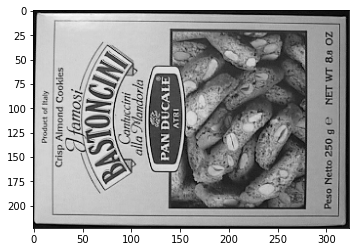

In [12]:
im1_path = Path('./sift_im1.png')
image = imread(im1_path, as_gray = True)
print('Image resolution: ', image.shape)
plt.imshow(image, cmap = 'gray')

#### Keypoint detection on original image

No. of initial keypoints:  238
No. of filtered keypoints:  98


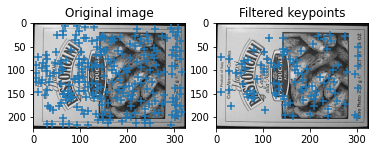

In [132]:
keypoints = detect_sift_keypoints(image)

#### Rotate image by 30 degree and detect SIFT keypoints

No. of initial keypoints:  132182
No. of filtered keypoints:  91


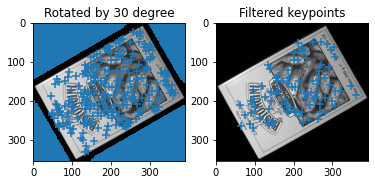

In [124]:
rotated_im = rotate(image, 30, resize = True)
keypoints = detect_sift_keypoints(rotated_im, transform = f'Rotated by 30 degree')

#### Upscale by 2X and detect SIFT keypoints

No. of initial keypoints:  1096
No. of filtered keypoints:  288


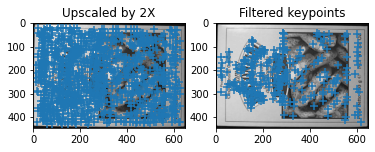

In [125]:
rescaled_im = rescale(image, 2)
keypoints = detect_sift_keypoints(rescaled_im, transform = f'Upscaled by 2X')

#### Blur image and detect SIFT keypoints

No. of initial keypoints:  161
No. of filtered keypoints:  29


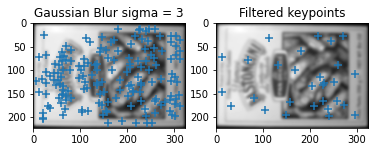

In [13]:
blur_img = gaussian(image, sigma=3)
keypoints = detect_sift_keypoints(blur_img, transform = f'Gaussian Blur sigma = 3')

#### Add gaussian noise to image and detect SIFT keypoint

No. of initial keypoints:  280
No. of filtered keypoints:  149


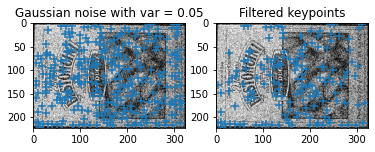

No. of initial keypoints:  291
No. of filtered keypoints:  156


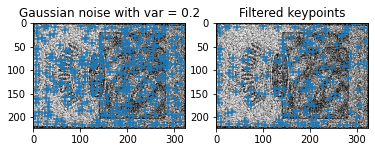

In [127]:
noisy_im = random_noise(image, mode='gaussian', var = 0.05)
keypoints = detect_sift_keypoints(noisy_im, transform = f'Gaussian noise with var = 0.05')

noisy_im = random_noise(image, mode='gaussian', var = 0.2)
keypoints = detect_sift_keypoints(noisy_im, transform = f'Gaussian noise with var = 0.2')

### Image2: SIFT Keypoint detection

In [12]:
im2_path = Path('./sift_im2.jpg')
image = imread(im2_path, as_gray = True)
print('Image resolution: ', image.shape)

Image resolution:  (706, 959)


#### Keypoint detection on original image

No. of initial keypoints:  3014
No. of filtered keypoints:  381


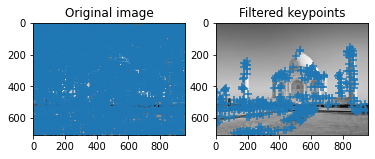

In [15]:
keypoints = detect_sift_keypoints(image)

#### Rotate image by 30 degree and detect SIFT keypoints

In [17]:
rotated_im = rotate(rescale(image, 0.5), 30, resize = True)
keypoints = detect_sift_keypoints(rotated_im, transform = f'Rotated by 30 degree')

#### Downscale to 0.5X and detect SIFT keypoints

No. of initial keypoints:  666
No. of filtered keypoints:  156


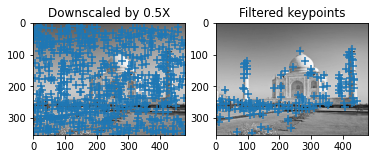

In [13]:
rescaled_im = rescale(image, 0.5)
keypoints = detect_sift_keypoints(rescaled_im, transform = f'Downscaled by 0.5X')

#### Blur image and detect SIFT keypoints

No. of initial keypoints:  2015
No. of filtered keypoints:  107


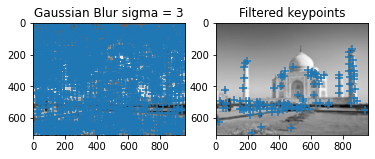

In [14]:
blur_img = gaussian(image, sigma=3)
keypoints = detect_sift_keypoints(blur_img, transform = f'Gaussian Blur sigma = 3')

#### Add gaussian noise to image and detect SIFT keypoint

No. of initial keypoints:  2367
No. of filtered keypoints:  534


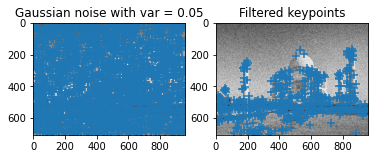

No. of initial keypoints:  2301
No. of filtered keypoints:  720


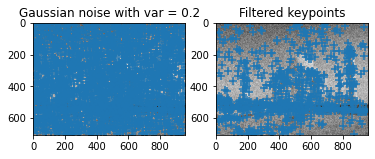

In [15]:
noisy_im = random_noise(image, mode='gaussian', var = 0.05)
keypoints = detect_sift_keypoints(noisy_im, transform = f'Gaussian noise with var = 0.05')

noisy_im = random_noise(image, mode='gaussian', var = 0.2)
keypoints = detect_sift_keypoints(noisy_im, transform = f'Gaussian noise with var = 0.2')